In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url

## Acquire

In [2]:
query = """
SELECT  bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet AS sqft, taxvaluedollarcnt AS tax_value, fips,taxamount 
FROM properties_2017
JOIN predictions_2017 USING (id)
JOIN propertylandusetype USING (propertylandusetypeid)
WHERE (transactiondate  >='2017-05-01' AND transactiondate <= '2017-06-30') AND propertylandusetypeid = '261'
AND taxvaluedollarcnt <= 1000000;
"""
df = pd.read_sql(query, get_db_url("zillow"))
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [3]:
df.dtypes

bathroomcnt    float64
bedroomcnt     float64
sqft           float64
tax_value      float64
fips           float64
taxamount      float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14860 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14860 non-null float64
bedroomcnt     14860 non-null float64
sqft           14828 non-null float64
tax_value      14860 non-null float64
fips           14860 non-null float64
taxamount      14828 non-null float64
dtypes: float64(6)
memory usage: 696.7 KB


## Prep

In [5]:
df = df.dropna()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14802 entries, 0 to 14859
Data columns (total 6 columns):
bathroomcnt    14802 non-null float64
bedroomcnt     14802 non-null float64
sqft           14802 non-null float64
tax_value      14802 non-null float64
fips           14802 non-null float64
taxamount      14802 non-null float64
dtypes: float64(6)
memory usage: 809.5 KB


In [7]:
df.fips.value_counts()

6037.0    11512
6059.0     2533
6111.0      757
Name: fips, dtype: int64

In [8]:
df.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31


In [9]:
LA = df[df['fips'] == 6037].fips
Orange = df[df['fips'] == 6059].fips
Ventura = df[df['fips'] == 6111].fips

In [10]:
df['tax_rate'] = df.taxamount / df.tax_value
df.head()


,bathroomcnt,bedroomcnt,sqft,tax_value,fips,taxamount,tax_rate
0,2.0,4.0,1604.0,498347.0,6037.0,6089.82,0.012220
1,3.0,3.0,2384.0,549917.0,6037.0,6679.55,0.012146
2,2.0,3.0,1574.0,235272.0,6037.0,3876.31,0.016476
3,2.0,2.0,1619.0,340000.0,6037.0,4206.15,0.012371
4,2.0,4.0,1721.0,629951.0,6037.0,6861.51,0.010892


## States and counties of the single unit properties located at
- By using Federal Information Processing Standards(fips) provided in the data, I found a link through google:
- https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697, in where it can be found that: 
- fips 6037 is correponding to Los Angeles county, CA
- fips 6059 is correponding to Orange county, CA
- fips 6111 is correponding to Ventura county, CA
- All of the three counties are located in the state of California.

In [11]:
LA = df[df['fips'] == 6037]
Orange = df[df['fips'] == 6059]
Ventura = df[df['fips'] == 6111]

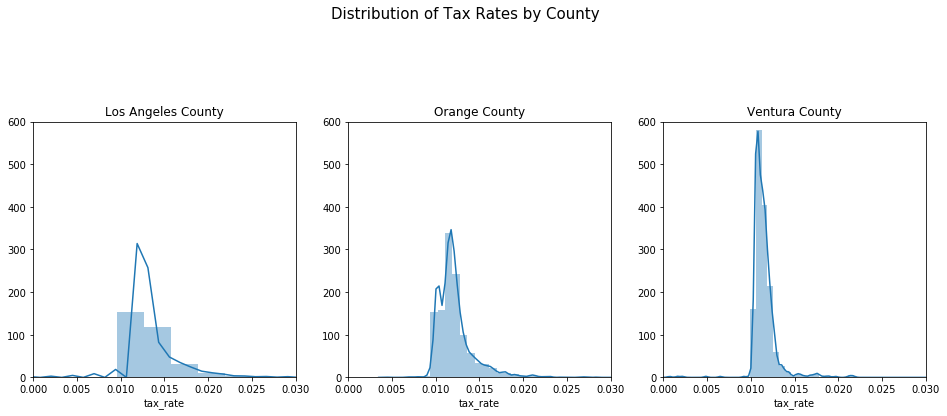

In [12]:
plt.figure(figsize=(16, 16))
plt.suptitle('Distribution of Tax Rates by County', fontsize=15)

plt.subplot(331)
sns.distplot(LA.tax_rate)
plt.xlim(0, .03)
plt.ylim(0, 600)
plt.title('Los Angeles County')

plt.subplot(332)
sns.distplot(Orange.tax_rate,)
plt.xlim(0, .03)
plt.ylim(0, 600)
plt.title('Orange County')

plt.subplot(333)
sns.distplot(Ventura.tax_rate,)
plt.xlim(0, .03)
plt.ylim(0, 600)
plt.title('Ventura County')
plt.show()

In [13]:
df.fips.value_counts()

6037.0    11512
6059.0     2533
6111.0      757
Name: fips, dtype: int64

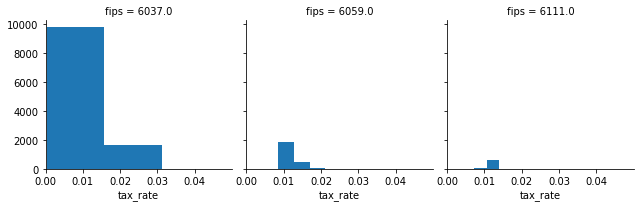

In [14]:
g = sns.FacetGrid(df, col = "fips")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.05)
plt.xticks(np.arange(0, .05, step=0.01))

plt.show()

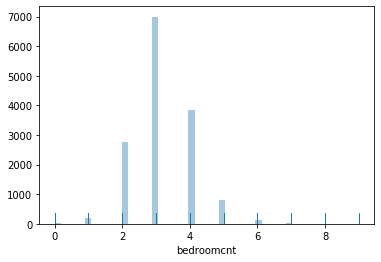

In [15]:
sns.distplot(df['bedroomcnt'],kde=False,rug=True)

In [16]:
df.bathroomcnt.sort_values()

12764    0.0
11364    0.0
5719     0.0
14636    0.0
9638     0.0
        ... 
1922     6.0
9729     7.0
9709     7.0
8515     7.0
9882     7.0
Name: bathroomcnt, Length: 14802, dtype: float64

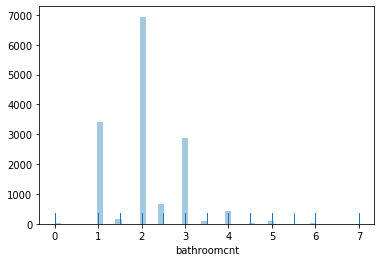

In [17]:
sns.distplot(df['bathroomcnt'],kde=False,rug=True)

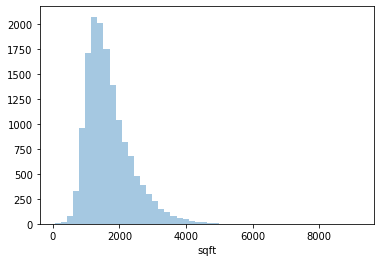

In [18]:
sns.distplot(df['sqft'],kde=False,rug=False)

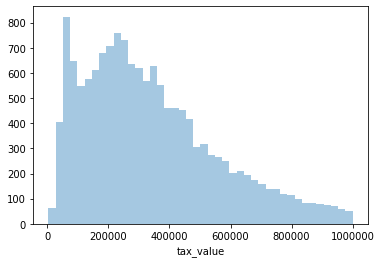

In [19]:
sns.distplot(df['tax_value'],kde=False,rug=False)

In [20]:
import split_scale

In [21]:
df = df[['bathroomcnt','bedroomcnt','sqft', 'tax_value']]

In [22]:
train, test = split_scale.split_my_data(df)

In [23]:
train.head()

,bathroomcnt,bedroomcnt,sqft,tax_value
5986,3.0,4.0,1960.0,229658.0
12828,1.0,3.0,961.0,202311.0
11807,1.0,2.0,690.0,692643.0
11208,3.0,4.0,2162.0,224000.0
10030,2.0,4.0,1470.0,678186.0


In [24]:
train.describe()

,bathroomcnt,bedroomcnt,sqft,tax_value
count,11841.000000,11841.000000,11841.000000,11841.000000
mean,2.073854,3.181404,1688.616586,339286.722659
std,0.821387,0.903837,684.381184,220503.057234
min,0.000000,0.000000,60.000000,5302.000000
25%,2.000000,3.000000,1211.000000,169935.000000
50%,2.000000,3.000000,1544.000000,296064.000000
75%,2.500000,4.000000,2017.000000,463419.000000
max,7.000000,9.000000,9200.000000,1000000.000000


In [25]:
scaler, train, test = split_scale.standard_scaler(train, test)

In [26]:
train.head(3)

,bathroomcnt,bedroomcnt,sqft,tax_value
5986,1.127588,0.905729,0.396555,-0.497197
12828,-1.307422,-0.200712,-1.063219,-0.621223
11807,-1.307422,-1.307153,-1.459214,1.602568


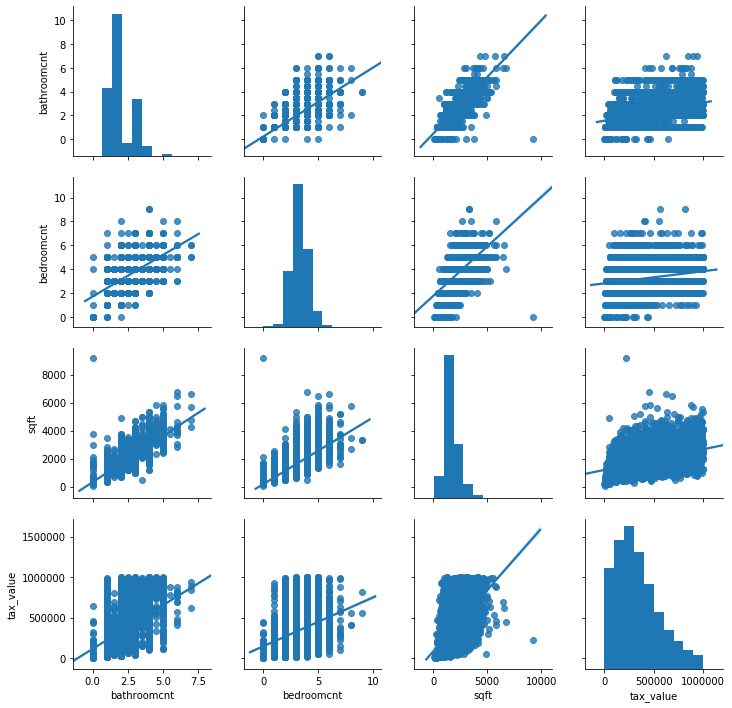

In [27]:
sns.pairplot(df, kind="reg")
plt.show()

# Exploration

(0, 4)

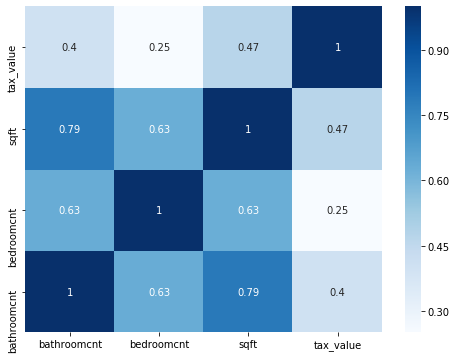

In [28]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.ylim(0, 4)

### Correlation Test

$H_0$: There is no linear relationship between sqft and tax_value.

$H_a$: There is a linear relationship between sqft and tax_value.

In [29]:
from math import sqrt
from scipy import stats

In [30]:
alpha = 0.01
r, p = stats.pearsonr(train.sqft, train.tax_value)
r, p

(0.47302490043214185, 0.0)

In [31]:
if p < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null")

Reject the null hypothesis


$H_0$: There is no linear relationship between bathroomcnt and tax_value.

$H_a$: There is a linear relationship between bathroomcnt and tax_value.

In [32]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.tax_value)
r, p

(0.4031011989652694, 0.0)

$H_0$: There is no linear relationship between bedroomcnt and tax_value.

$H_a$: There is a linear relationship between bedroomcnt and tax_value.

In [33]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.tax_value)
r, p

(0.25070392818053844, 3.826869470604966e-169)

$H_0$: There is no linear relationship between bathroomcnt and sqft.

$H_a$: There is a linear relationship between bathroomcnt and sqft.

In [34]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.sqft)
r, p

(0.7907649969357715, 0.0)

$H_0$: There is no linear relationship between bathroomcnt and bedroomcnt.

$H_a$: There is a linear relationship between bathroomcnt and bedroomcnt.

In [35]:
alpha = 0.01
r, p = stats.pearsonr(train.bathroomcnt, train.bedroomcnt)
r, p

(0.6339995152150681, 0.0)

$H_0$: There is no linear relationship between bedroomcnt and sqft.

$H_a$: There is a linear relationship between bedroomcnt and sqft.

In [36]:
alpha = 0.01
r, p = stats.pearsonr(train.bedroomcnt, train.sqft)
r, p

(0.6261586116589335, 0.0)

## Insights drawn from correlation tests

- Among independent variables (bathroomcnt,bedroomcnt,sqft) and dependent variable (tax_value), there is a weak-postive linear relatioship between sqft and tax_value; there is also a weak-positive linear relatioship between bathroomcnt and tax_value; there is a very weak-positive linear relatioship between bedroomcnt and tax_value,

- Among independent variables themsleves, there is a strong-postive linear relationship between bathroomcnt and sqft; there is a moderate-postive linear relatioship between bathroomcnt and bedroomcnt; there is also a moderate-postive linear relationship between bedroomcnt and sqft.

# Modeling

In [37]:
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.linear_model
import warnings
warnings.filterwarnings("ignore")
import split_scale

In [38]:
predictions = pd.DataFrame({
    'actual_tax_value': train.tax_value
})
predictions.head()

,actual_tax_value
5986,-0.497197
12828,-0.621223
11807,1.602568
11208,-0.522857
10030,1.537002


In [39]:
predictions['baseline'] = predictions.actual_tax_value.mean()
predictions.head(3)

,actual_tax_value,baseline
5986,-0.497197,9.765668e-17
12828,-0.621223,9.765668e-17
11807,1.602568,9.765668e-17


In [40]:
predictions.head(3)

,actual_tax_value,baseline
5986,-0.497197,9.765668e-17
12828,-0.621223,9.765668e-17
11807,1.602568,9.765668e-17


In [41]:
X = train[['bathroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath_lm'] = lm.predict(X)

In [42]:
X = train[['bedroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed_lm'] = lm.predict(X)

In [43]:
X = train[['sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['sqft_lm'] = lm.predict(X)

In [44]:
X = train[['bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bed&sqft_lm'] = lm.predict(X)

In [45]:
X = train[['bathroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&sqft_lm'] = lm.predict(X)

In [46]:
X = train[['bathroomcnt','bedroomcnt']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed_lm'] = lm.predict(X)

In [47]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
lm = sklearn.linear_model.LinearRegression()
lm.fit(X, y)
predictions['bath&bed&sqft_lm'] = lm.predict(X)

In [48]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual_tax_value, col))

actual_tax_value    0.000000
baseline            1.000000
bath_lm             0.837509
bed_lm              0.937148
sqft_lm             0.776247
bed&sqft_lm         0.772844
bath&sqft_lm        0.773995
bath&bed_lm         0.837470
bath&bed&sqft_lm    0.768309
dtype: float64

In [49]:
def select_rfe(X, y, k):
    lm = sklearn.linear_model.LinearRegression()
    rfe = sklearn.feature_selection.RFE(lm, k)
    rfe.fit(X, y)
    return X.columns[rfe.support_]

In [50]:
X = train[['bathroomcnt','bedroomcnt','sqft']]
y = train.tax_value
k = 2
select_rfe(X, y, k)

Index(['bathroomcnt', 'sqft'], dtype='object')

In [51]:
def select_kbest(X, y, k):
    kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k)
    kbest.fit(X, y)
    return X.columns[kbest.get_support()]

In [52]:
select_kbest(X, y, k)

Index(['bathroomcnt', 'sqft'], dtype='object')

In [53]:
predictions.head(3)

,actual_tax_value,baseline,bath_lm,bed_lm,sqft_lm,bed&sqft_lm,bath&sqft_lm,bath&bed_lm,bath&bed&sqft_lm
5986,-0.497197,9.765668e-17,0.454532,0.227070,0.187580,0.138392,0.250690,0.452980,0.214728
12828,-0.621223,9.765668e-17,-0.527023,-0.050319,-0.502929,-0.537723,-0.539110,-0.532130,-0.603598
11807,1.602568,9.765668e-17,-0.527023,-0.327709,-0.690245,-0.660807,-0.702148,-0.523135,-0.668127


In [54]:
# 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of tip using total_bill.
from statsmodels.formula.api import ols
model = ols('tax_value ~ bathroomcnt', df).fit()
df['yhat'] = model.predict(df.bathroomcnt)

In [55]:
df.head()

,bathroomcnt,bedroomcnt,sqft,tax_value,yhat
0,2.0,4.0,1604.0,498347.0,330723.696744
1,3.0,3.0,2384.0,549917.0,438770.582473
2,2.0,3.0,1574.0,235272.0,330723.696744
3,2.0,2.0,1619.0,340000.0,330723.696744
4,2.0,4.0,1721.0,629951.0,330723.696744


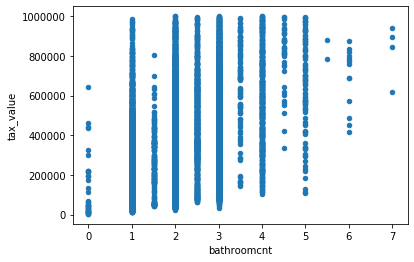

In [56]:
df.plot.scatter(y='tax_value', x='bathroomcnt')

In [57]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              tax_value   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     2892.
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:31:57   Log-Likelihood:            -2.0173e+05
No. Observations:               14802   AIC:                         4.035e+05
Df Residuals:                   14800   BIC:                         4.035e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.146e+05   4480.395     25.585      0.000    1.06e+05    1.23e+05
bathroomcnt   1.08e+05   2009.304     53.773      0.000    1.04e+05    1.12e+05
==============================================================================
Omnibus:                      953.465   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1147.740
Skew:                           0.679   Prob(JB):                    5.91e-250
Kurtosis:                       3.133   Cond. No.                         7.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
pwd

'/Users/wenliangsun/codeup-data-science/zillow_project'